# Tensorized grids

In this notebook we will learn how to

* create 1D, 2D, 3D grids (`grid1d`, `grid`),
* discretize a function on the grid, and
* visualize a function (`plot`, `imshow`).

[Back to tensorgrid quick introduction](00_quick_introduction.ipynb). 

*&#169; Copyright 2019-2023 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import exp, sin, cos

import expsolve.discretize.tensorgrid as ex

c:\ProgramData\Anaconda3\envs\torchcomplex\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Creating a 1D grid

The first step in solving a PDE using `expsolve` is to create a grid to discretise our initial functions. These are the grid points on which the numerical solution is computed.


#### $\star$ `grid1d`

A 1-dimensional grid over the spatial domain `[-1,1]` can be created with the `grid1d` function. 

```Python
    x = ex.grid1d(n)
```
where `n` is the number of grid points.

In [2]:
x = ex.grid1d(10)

Let us check the properties of the grid

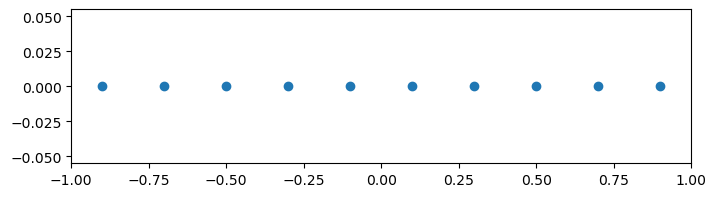

tensor([[-0.9000, -0.7000, -0.5000, -0.3000, -0.1000,  0.1000,  0.3000,  0.5000,
          0.7000,  0.9000]], dtype=torch.float64)
torch.Size([1, 10])
torch.float64


In [3]:
plt.figure(figsize=(8,2))
plt.scatter(x, torch.zeros(x.shape))
plt.xlim(-1, 1)
plt.show()

print(x)
print(x.shape)
print(x.dtype)

A few points to note:

* By default grids are created as `torch.tensor` objects with `double` (i.e. `float64`) accuracy. This makes any function computed on these grids a `torch.tensor` with `float64` accuracy (or `complex128` if the function is complex-valued). This accuracy can be changed by specifying the parameter `dtype`.

* Even a 1D grid is created as a tensor of dimensions `1 x n` where `n` is the number of grid points. This allows `expsolve` to parallelize computations in many applications (such as parameter sweep, optimization and machine learning). This is illustrated with examples in the notebooks `[FIX] BATCH PROCESSING`.

* In the `tensorgrid` module we always assume periodic boundary conditions, and thus at most one of $x=-1$ or $x=1$ should be kept. We take a symmetric approach, i.e. the grids created are symmetric around $x=0$. Thus neither $x=\pm1$ is included, and the origin $x=0$ is only included in a grid with an odd number of points.

If a grid over a different spatial domain `xrange` is sought, we can use the following syntax:

```Python
    x = ex.grid1d(n, xrange)
```
where `n` is the number of grid points and `xrange` is a list of two elements, e.g. `[a,b]` where `a` is the left boundary and `b` the right boundary of the periodic domain. 

Once again, keep in mind that these periodic grids are symmetric and neither end point (`a` or `b`) is included among the grid points. This is in contrast to other periodic grids which may include the rightmost point (`b`) and exclude the leftmost point (`a`), for instance.

**NOTE:** The default value of `xrange` is `[-1,1]` in **all** functions in `expsolve`. 

In [4]:
xrange=[2, 5]
x = ex.grid1d(15, xrange)
print(x)
print(x.shape)

tensor([[2.1000, 2.3000, 2.5000, 2.7000, 2.9000, 3.1000, 3.3000, 3.5000, 3.7000,
         3.9000, 4.1000, 4.3000, 4.5000, 4.7000, 4.9000]], dtype=torch.float64)
torch.Size([1, 15])


We can create grids with different precision by specifying the optional `dtype` parameter.

In [5]:
x64 = ex.grid1d(15)
x32 = ex.grid1d(15, dtype=torch.float32)
x16 = ex.grid1d(15, dtype=torch.float16)

print(x64.dtype)
print(x32.dtype)
print(x16.dtype)

torch.float64
torch.float32
torch.float16


## Sampling a function



Sampling a function on a grid is pretty simple: just call the function on the grid you have created.

* `expsolve` is based on PyTorch and all functions used need to be `torch` based rather than `numpy based`.

* You can perform all torch operations on the grid or the functions as usual.

* The behaviour of `dtype` is the usual `torch` behaviour: i.e. the data type is upgraded to the highest precision among the operands, and `float64` is upgraded to `complex128` when complex-valued operations are carried out on a `float64`, for example.

In [6]:
s = torch.sin(x64)
e = torch.exp(x32)
ei = torch.exp(1j*x32)
r = 100.*s + e + e*s
y = x16**3 + x16

print(s.dtype)
print(e.dtype)
print(ei.dtype)
print(r.dtype)
print(y.dtype)


torch.float64
torch.float32
torch.complex64
torch.float64
torch.float16


From here onwards, we will import `sin`, `cos`, `exp` and other basic functions from `torch`, so we don't have to use `torch.sin` etc.

## Visualizing functions

#### $\star$ `plot`

You can use any library for visualizing the data. However, `tensorgrid` provides some handy tools that take care of some common pre-processing such as changing the shape of the grid and function from `1 x n` to `n` before plotting. 

`expsolve.discretize.tensorgrid`'s (i.e. `ex`'s) `plot` function is a light wrapper around `matplotlib.pyplot.plot`. 

* We have imported `matplotlib.pyplot` here (and in all other notebooks) as `plt`. This needs to be the first parameter to `ex.plot`. 

* `ex.plot` can only handle one pair of `x`, `y` data in a single call.

For all other purposes `ex.plot` behaves the same as `plt.plot` and can be used with other `plt` functionalities such as legend, labels, x and y limits etc.

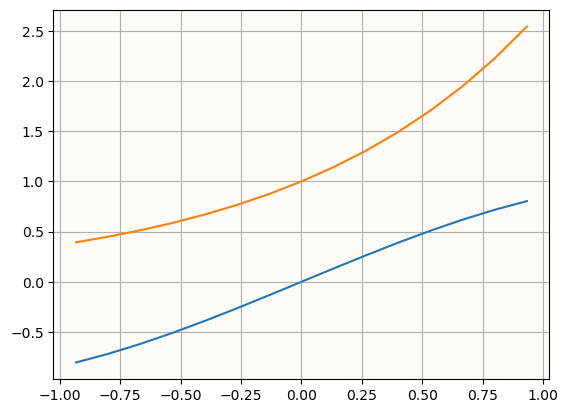

In [7]:
fig, ax = plt.subplots()
ex.plot(ax, x16, s)
ex.plot(ax, x16, e)
plt.show()

Note that the precision of `x` and `y` does not have to match here. We used `x16` to demonstrate this, even though `s` and `e` have higher precisions.

Just like in `matplotlib.pyplot.plot`, it is possible for you to skip `x` axis data.

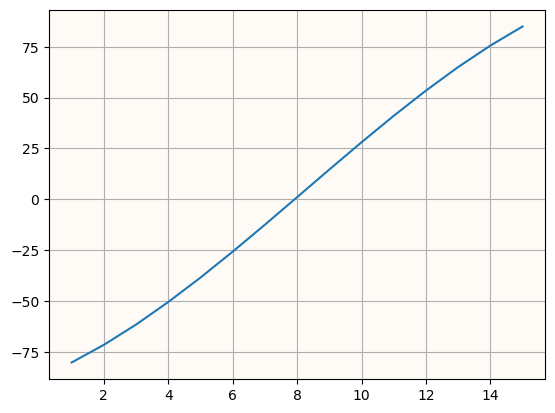

In [8]:
fig, ax = plt.subplots()
ex.plot(ax, r)
plt.show()

## Creating a 2D grid

#### $\star$ `grid`

A 2-dimensional grid over the spatial domain `[-1,1]^2` can be created with the `grid` function. 

```Python
    [x, y] = ex.grid([nx, ny])
```
where `nx` is the number of grid points in direction `x` and `ny` the number of grid points in the direction `y`. 

In [9]:
[x, y] = ex.grid([15,8])

The shapes of `x` and `y` are both `1 x nx x ny`.

In [10]:
print(x.shape)
print(y.shape)

torch.Size([1, 15, 8])
torch.Size([1, 15, 8])


We visualize the grid with a scatter plot as before.

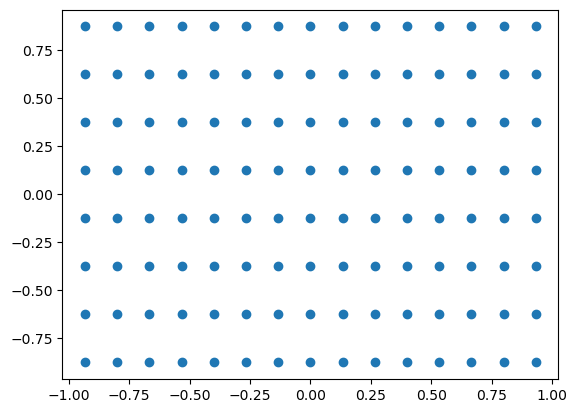

In [11]:
plt.scatter(x, y)
plt.show()

If a grid over a different spatial domain `[a,b]^2` is sought, we can use the following syntax:

```Python
    [x, y] = ex.grid([nx, ny], xrange=[a,b])
```
or simply

```Python
    [x, y] = ex.grid([nx, ny], [a,b])
```


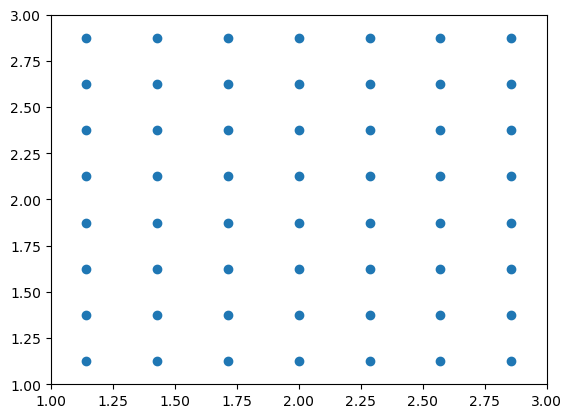

In [12]:
xrange = [1, 3]
n = [7, 8]
[x, y] = ex.grid(n, xrange)

plt.scatter(x, y)
plt.xlim(xrange)
plt.ylim(xrange)
plt.show()

If the range in the two dimensions is not identical, e.g. we want a domain $[a_x, b_x] \times [a_y, b_y]$, we can specify it as a numpy array of size $2 \times 2$.

```Python
    [x, y] = ex.grid([nx, ny], xrange=xrange)
```
or simply
```Python
    [x, y] = ex.grid([nx, ny], xrange)
```

where
```Python
    xrange = np.array([[ax, bx], [ay, by]])
```

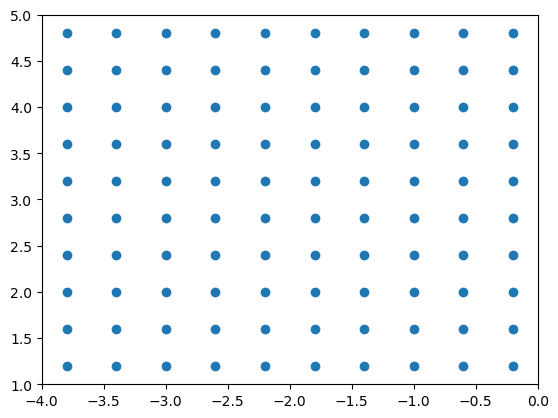

In [13]:
xr = [-4,0]
yr = [1,5]
[x, y] = ex.grid([10, 10], xrange=np.array([xr, yr]))

plt.scatter(x, y)
plt.xlim(xr)
plt.ylim(yr)
plt.show()

## Sampling and visualizing a function

Sampling a function is very similar to 1D: We just evaluate the function on the grid just created!

In [14]:
xrange=np.array([[-4,0], [1,5]])
[x, y] = ex.grid([100,100], xrange)

s = sin(x)
c = cos(y)
r = x**2 + y**2 + x*y + exp(x-y)

#### $\star$ `imshow`

We can visualize the functions using the `imshow` function in `tensorgrid` (i.e., `ex`) as

```Python
    ex.imshow(plt, xrange, f)
```

where `f` is the function to be displayed, and `xrange` is a valid numpy array describing the range.

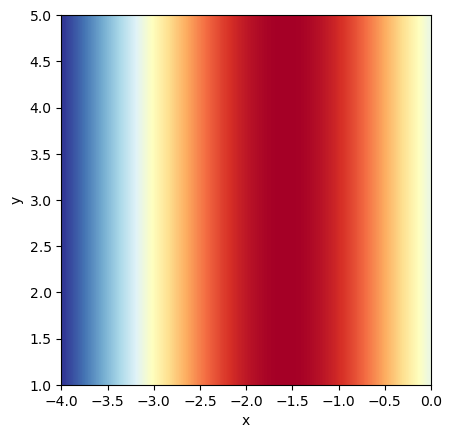

In [17]:
fig, ax = plt.subplots()
ex.imshow(ax, xrange, s)
plt.show()

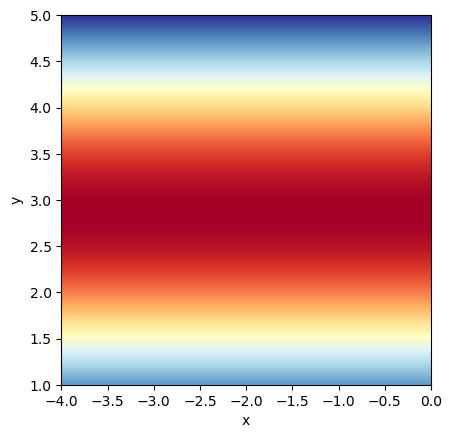

In [18]:
fig, ax = plt.subplots()
ex.imshow(ax, xrange, c)
plt.show()

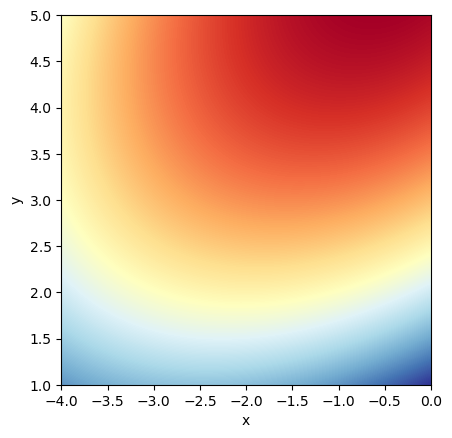

In [19]:
fig, ax = plt.subplots()
ex.imshow(ax, xrange, r)
plt.show()

## Higher dimensions

Similar to the 2D case, we can create a 3-dimensional grid, for example on the domain `[-4, 0] x [1,5] x [-2,1]`

In [20]:
xrange = np.array([[-4, 0], [1, 5], [-2, 1]])
[x, y, z] = ex.grid([12, 15, 8], xrange)

r = x * y * z + sin(x-z) + cos(z*y) + exp(z+x**2)
print(r.shape)

torch.Size([1, 12, 15, 8])


Or create a 6 dimensional grid on $[-1,1]^6$, 

In [21]:
X = ex.grid([6, 8, 4, 10, 4, 5])
r = X[0] * X[3] * X[5] + X[1] - sin(X[0]) + exp(X[5] - X[1]**2) 
print(r.shape)

torch.Size([1, 6, 8, 4, 10, 4, 5])


Here we have used the default `xrange`, but a custom one can be specified. `X` is a list of `6` directional (mesh)grid values that are used to compute the function `r`. 

Methods for visualizing higher dimension data are currently unavailable, but differential equations can be solved on grids of arbitrary dimensions provided the data fits in memory.